# Pothole Detection

### Install and Import Dependencies

In [3]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [59]:
pip install sklearn

  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2349 sha256=39415b74e85e2c97039c330e5775e669c1b2487175f39aac561815430d882638
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\42\56\cc\4a8bf86613aafd5b7f1b310477667c1fca5c51c3ae4124a003
Successfully built sklearn
Note: you may need to restart the kernel to use updated packages.


In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import os
from sklearn.model_selection import train_test_split
import keras
import pandas as pd
import seaborn as sns

### Data

This data comes from the [Cracks and Potholes in Road Images Dataset](https://github.com/biankatpas/Cracks-and-Potholes-in-Road-Images-Dataset/tree/master/Dataset). It is licensed under the MIT License, giving us permission to modify and distribute the data for both private and commercial use.

DATA DESCRIPTION

### Create Dataset

The first step is to create the dataset with the images, their labels, and the parameters for the pothole bounding boxes. We will use **keras** to load and convert images to numpy arrays, and **cv2** to detect the potholes and label them. We store the dataset as a csv file.

Below is an example of how cv2 creates a bounding box around a pothole using the provided masks.

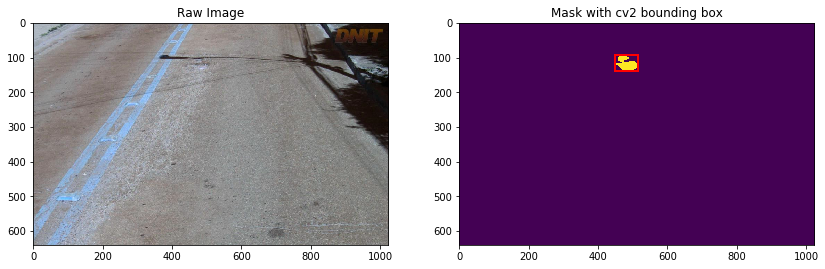

In [35]:
master = 'biankatpas Cracks-and-Potholes-in-Road-Images-Dataset master Dataset'
path = master + "/820315_ES_259_259ES000000_03060/820315_ES_259_259ES000000_03060_RAW.jpg"
raw_img = cv2.imread(path)
path = master + "/820315_ES_259_259ES000000_03060/820315_ES_259_259ES000000_03060_POTHOLE.png"
mask = cv2.imread(path, 0)
x,y,w,h = cv2.boundingRect(mask)
fig, axs = plt.subplots(1,2, figsize=(14,20))
axs[0].set_title("Raw Image")
axs[0].imshow(raw_img)
axs[1].set_title("Mask with cv2 bounding box")
axs[1].imshow(mask)
axs[1].add_patch(patches.Rectangle((x,y),w,h, fill=False, edgecolor='red', lw=2))

In [ ]:
# Create Train/Validation csv
imgs = []
img_paths = []
width = []
height = []
pothole = []
x_center = []
y_center = []
box_w = []
box_h = []
box = []

master = 'biankatpas Cracks-and-Potholes-in-Road-Images-Dataset master Dataset'
samples = os.listdir(master)
for sample in samples:
    # Path for Raw Image
    img_path = master + "/" + sample + "/" + sample + "_RAW.jpg"
    img_paths.append(img_path)
    img = keras.preprocessing.image.load_img(img_path, (640, 1024))
    img = keras.preprocessing.image.img_to_array(img)
    imgs.append(img)
    
    # Image Dimensions
    width.append(1024)
    height.append(640)
    
    # Get bounding box of image
    path = master + "/" + sample + "/" + sample + "_POTHOLE.png"
    mask = cv2.imread(path, 0)
    # Convert from 0-255 to 0-1
    mask = (mask > 0).astype(np.uint8)
    mask = cv2.resize(mask,[600,600],cv2.INTER_NEAREST)
    x,y,w,h = cv2.boundingRect(mask)
    x_center.append(x)
    y_center.append(y)
    box_w.append(w)
    box_h.append(h)
    box.append((x,y,w,h))
    
    # Get label
    if ((x == 0) and (y == 0) and (w == 0) and (h == 0)):
        label = 0
    else:
        label = 1
    pothole.append(label)

# Create Df and csv
df = pd.DataFrame({'img':imgs, 'img_path':img_paths , 'width':width, 'height':height, 'pothole':pothole, 'x_center':x_center, 'y_center':y_center, 'box_w':box_w, 'box_h':box_h, 'box':box})
df.to_csv('pothole_data.csv', index=None)

In [ ]:
# Load data from csv
potholes = pd.read_csv('pothole_data.csv')
potholes.head()

### Data Exploration

We are working with a dataset that contains $2235$ samples (images). The target classes are $0$ and $1$, which correspond to the given road containing a pothole ($1$) or not ($0$)

In [40]:
# Number of Observations
len(potholes)

2235

In [42]:
# Number of Classes
np.unique(potholes['pothole'])

array([0, 1], dtype=int64)

#### Class distribution

As we can see in the target class distribution, the data is a bit imbalanced. We have $564$ samples with potholes, and $1671$ samples without. This prior could lead to problems, and we will need to adjust how we train our model accordingly.

Images with potholes: 564
Images without potholes: 1671


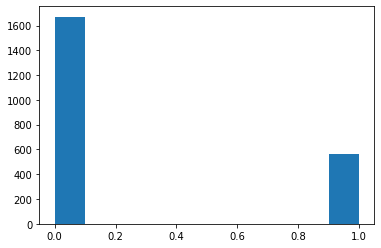

In [49]:
# Class distribution
plt.hist(potholes['pothole'])
print("Images with potholes: " + str(len(potholes[potholes['pothole']>0])))
print("Images without potholes: " + str(len(potholes[potholes['pothole']<1])))

#### Distribution of bounding box widths and heights

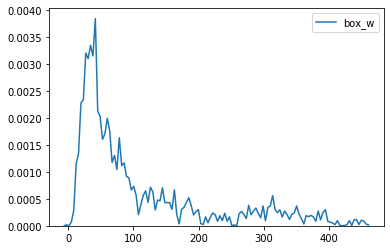

In [50]:
# Distribution of bounding box widths
sns.kdeplot(potholes['box_w'])

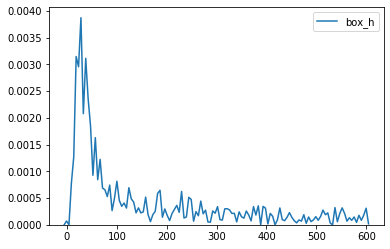

In [53]:
# Distribution of bouding box heights
sns.kdeplot(potholes['box_h'])

#### Examples of each target class

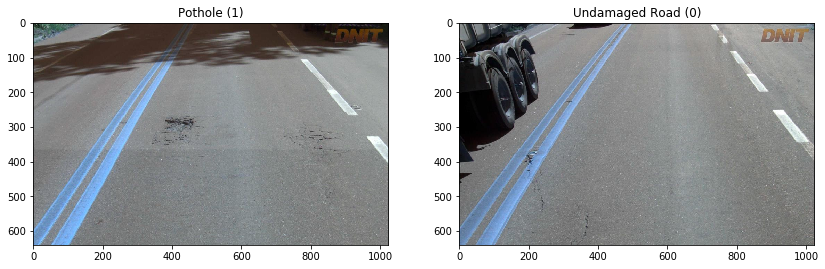

In [59]:
# Plot Examples of Classes
master = 'biankatpas Cracks-and-Potholes-in-Road-Images-Dataset master Dataset'
path = master + "/765254_ES_259_259ES000000_00370/765254_ES_259_259ES000000_00370_RAW.jpg"
pothole_example = cv2.imread(path)
path = master + "/765442_ES_259_259ES000000_01310/765442_ES_259_259ES000000_01310_RAW.jpg"
undamaged_example = cv2.imread(path)
fig, axs = plt.subplots(1,2, figsize=(14,20))
axs[0].set_title("Pothole (1)")
axs[0].imshow(pothole_example)
axs[1].set_title("Undamaged Road (0)")
axs[1].imshow(undamaged_example)

In [ ]:
# Missing Data
# Image size/Resize
# Normalized?
# How will we preprocess our data

### Train/Validate split

In [76]:
# Train/Valitate split
train, val, a, b = train_test_split(potholes, potholes,test_size = 0.2)
train_imgs = np.array(train['img'])
train_targets = np.array(train['box'])

In [77]:
train_targets

array([[339,   0,   0, ...,   0,   0,   0],
       [196,   0,   0, ...,   0,   0,   0],
       [ 31,   0,   0, ...,   0,   0,   0],
       [ 16,   0,   0, ...,   0,   0,   0]], dtype=int64)